[View in Colaboratory](https://colab.research.google.com/github/SukritJaidee/dataset/blob/master/forecast_eecu_by_rnn.ipynb)

# Edit 30/9/2018

# import neccessary library

In [0]:
# import neccessary library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

**Install library for colab**

In [2]:
!pip install xlrd

# 1. Preprocessing Data
# 1.1 Import and Cleansing Data

In [4]:
from google.colab import files
uploaded = files.upload()

Saving solar_eecu_imputed2017to2018_ds30min_ema_SCK.xlsx to solar_eecu_imputed2017to2018_ds30min_ema_SCK (1).xlsx


In [8]:
solar_input = pd.read_excel('solar_eecu_imputed2017to2018_ds30min_ema_SCK.xlsx')
solar_input.head(2)

,date_time,EMA_now,Iradiance,Power,Temperature
0,2017-01-01 00:00:00,0.0,0.0,0.0,26.450000
1,2017-01-01 00:30:00,0.0,0.0,0.0,26.081818


In [9]:
solar_input.drop(('date_time'), axis=1, inplace=True)
print(solar_input.shape)

(26208, 4)


In [10]:
solar_input.head(2)

,EMA_now,Iradiance,Power,Temperature
0,0.0,0.0,0.0,26.450000
1,0.0,0.0,0.0,26.081818


# 2. Preprocessing

In [0]:
#EMA 8 จุด
EMA_30min = solar_input.iloc[1:,0] #เอา col EMA_now ตั้งแต่แถวที่ 1 มา ไม่เอาแถวที่ 0
EMA_60min = solar_input.iloc[2:,0] #เอา col EMA_now ตั้งแต่แถวที่ 2 มา ไม่เอาแถวที่ 0-1
EMA_90min = solar_input.iloc[3:,0] #เอา col EMA_now ตั้งแต่แถวที่ 3 มา ไม่เอาแถวที่ 0-2
EMA_120min = solar_input.iloc[4:,0] #เอา col EMA_now ตั้งแต่แถวที่ 4 มา ไม่เอาแถวที่ 0-3
EMA_150min = solar_input.iloc[5:,0]
EMA_180min = solar_input.iloc[6:,0]
EMA_210min = solar_input.iloc[7:,0]
EMA_240min = solar_input.iloc[8:,0] #เอา col EMA_now ตั้งแต่แถวที่ 8 มา ไม่เอาแถวที่ 0-7

#power 7 จุด
Power_30min = solar_input.iloc[1:,2] #เอา col Power ตั้งแต่แถวที่ 1 มา ไม่เอาแถวที่ 0
Power_60min = solar_input.iloc[2:,2] #เอา col Power ตั้งแต่แถวที่ 2 มา ไม่เอาแถวที่ 0-1
Power_90min = solar_input.iloc[3:,2]
Power_120min = solar_input.iloc[4:,2]
Power_150min = solar_input.iloc[5:,2]
Power_180min = solar_input.iloc[6:,2]
Power_210min = solar_input.iloc[7:,2] #เอา col Power ตั้งแต่แถวที่ 7 มา ไม่เอาแถวที่ 0-6

zero_1 = pd.Series([0]*1) #สร้าง data Series ของศูนย์ 1 ตัว
zero_2 = pd.Series([0]*2) #สร้าง data Series ของศูนย์ 2 ตัว
zero_3 = pd.Series([0]*3)
zero_4 = pd.Series([0]*4)
zero_5 = pd.Series([0]*5)
zero_6 = pd.Series([0]*6)
zero_7 = pd.Series([0]*7)
zero_8 = pd.Series([0]*8) #สร้าง data Series ของศูนย์ 8 ตัว

In [0]:
#ทำการ shift ค่าเพื่อทำการ predict
EMA_30min=pd.DataFrame(EMA_30min.append(zero_1, ignore_index=True), columns=['EMA_30min'])  #เอา "0" 1 ตัวมาต่อท้าย
EMA_60min=pd.DataFrame(EMA_60min.append(zero_2, ignore_index=True),columns=['EMA_60min']) #เอา "0" 2 ตัวมาต่อท้าย
EMA_90min=pd.DataFrame(EMA_90min.append(zero_3, ignore_index=True),columns=['EMA_90min'])
EMA_120min=pd.DataFrame(EMA_120min.append(zero_4, ignore_index=True),columns=['EMA_120min'])
EMA_150min=pd.DataFrame(EMA_150min.append(zero_5, ignore_index=True),columns=['EMA_150min'])
EMA_180min=pd.DataFrame(EMA_180min.append(zero_6, ignore_index=True),columns=['EMA_180min'])
EMA_210min=pd.DataFrame(EMA_210min.append(zero_7, ignore_index=True),columns=['EMA_210min'])
EMA_240min=pd.DataFrame(EMA_240min.append(zero_8, ignore_index=True),columns=['EMA_240min']) #เอา "0" 8 ตัวมาต่อท้าย

Power_30min=pd.DataFrame(Power_30min.append(zero_1, ignore_index=True),columns=['Power_30min']) #เอา "0" 1 ตัวมาต่อท้าย
Power_60min=pd.DataFrame(Power_60min.append(zero_2, ignore_index=True),columns=['Power_60min']) #เอา "0" 2 ตัวมาต่อท้าย
Power_90min=pd.DataFrame(Power_90min.append(zero_3, ignore_index=True),columns=['Power_90min'])
Power_120min=pd.DataFrame(Power_120min.append(zero_4, ignore_index=True),columns=['Power_120min'])
Power_150min=pd.DataFrame(Power_150min.append(zero_5, ignore_index=True),columns=['Power_150min'])
Power_180min=pd.DataFrame(Power_180min.append(zero_6, ignore_index=True),columns=['Power_180min'])
Power_210min=pd.DataFrame(Power_210min.append(zero_7, ignore_index=True),columns=['Power_210min']) #เอา "0" 7 ตัวมาต่อท้าย

In [15]:
ggg = pd.concat([solar_input.iloc[:,0],EMA_30min,EMA_60min,EMA_90min,EMA_120min,EMA_150min,EMA_180min,EMA_210min,EMA_240min, solar_input.iloc[:,1], solar_input.iloc[:,3], solar_input.iloc[:,2],Power_30min,Power_60min,Power_90min,Power_120min,Power_150min,Power_180min,Power_210min], axis = 1)
ggg

,EMA_now,EMA_30min,EMA_60min,EMA_90min,EMA_120min,EMA_150min,EMA_180min,EMA_210min,EMA_240min,Iradiance,Temperature,Power,Power_30min,Power_60min,Power_90min,Power_120min,Power_150min,Power_180min,Power_210min
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,26.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,26.081818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.881818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.690909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.572727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.281818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065455
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065455,0.261818
9,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,24.909091,0.000000,0.000000,0.000000,0.000000,0.000000,0.065455,0.261818,0.621818


In [16]:
ggg.shape

(26208, 19)

## 3. Prepare input of time series

In [0]:
def get_batch(X_origin, steps, start_indices):
    '''
    This method will generate input and output of time-series for RNN, for example
    input --> x(t-2) x(t-1) x(t)
    target --> x(t-1) x(t) x(t+1)
    '''
    X = X_origin.copy()
    
    start = start_indices[0]
    train_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 19)
    
    train_return = train_batch[:-1,:-7].reshape(-1, steps, 12) #train_batch[:-1,:-5]
    target_return = train_batch[1:,-8:].reshape(-1, steps, 8) # train_batch[1:,-5:]
    
    for k, start in enumerate(start_indices):
        
        if k != 0:
            train_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 19)[:-1,:-7].reshape(-1, steps, 12)
            target_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 19)[1:,-8:].reshape(-1, steps, 8)
            train_return = np.concatenate((train_return, train_batch), axis = 0)
            target_return = np.concatenate((target_return, target_batch), axis = 0)
    
    return train_return, target_return

In [20]:
## Unit Test
solar_mat = ggg.as_matrix().copy() #Solar_input -->ggg
solar_mat[0:4, :].reshape(4,19)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        26.45      ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        26.08181818,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        25.88181818,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        25.690

In [21]:
solar_mat.shape

(26208, 19)

In [22]:
# split train and test set
test_set_ratio = 0.05
full_len = solar_mat.shape[0]

len_train = round(full_len*(1-test_set_ratio))

solar_train_origin = ggg.iloc[:len_train, :].as_matrix().copy() #Solar_input -->ggg
solar_test_origin = ggg.iloc[len_train+1:, :].as_matrix().copy() #Solar_input -->ggg

print('data train shape', len(solar_train_origin))
print('data test shape', len(solar_test_origin))

data train shape 24898
data test shape 1309


In [0]:
solar_train_origin_data = pd.DataFrame(solar_train_origin)

In [0]:
solar_test_origin_data = pd.DataFrame(solar_test_origin)

In [25]:
solar_train_origin_data.shape

(24898, 19)

In [26]:
solar_test_origin_data.shape

(1309, 19)

In [27]:
print(full_len)
print(len_train)

26208
24898


In [28]:
# normalize input
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
solar_train_origin_scale = scaler.fit_transform(solar_train_origin)
solar_test_origin_scale = scaler.transform(solar_test_origin)

scaler.data_min_.shape


(19,)

In [0]:
def inverse_transform(input_, scaler):
    min_data = scaler.data_min_[12]   #index of power in ggg
    max_data = scaler.data_max_[12]
    
    return input_*(max_data - min_data) + min_data
    

In [0]:
output_ = inverse_transform(solar_test_origin_scale[:,-8:], scaler) #4or5 is ok

In [31]:
output_.shape

(1309, 8)

In [32]:
np.sum(output_ - solar_test_origin[:,-8:])

-2.0863866190268254e-13

# 4 Model Selection

In [0]:
num_inputs = 12
num_outputs = 8

num_time_steps = 12
forecast_steps = 1

## layers of RNN 
num_layers = 2      
## dropout regularization
keepprob = 0.8         

learning_rate = 0.005
num_neurons = 256
batch_size = 2**5

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.9)


In [0]:
import tensorflow as tf

# RNN
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs], name = 'X')
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs], name = 'Y')
tf_keepprob = tf.placeholder(tf.float32, name='tf_keepprob')

#######################################################################################
## GRUCell regularization
save_name = './GG6_GRU_model'
cells = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.MultiRNNCell(
        [tf.contrib.rnn.DropoutWrapper(
            tf.contrib.rnn.GRUCell(num_neurons, activation = tf.nn.relu,
                                   kernel_initializer = tf.contrib.layers.xavier_initializer()),
            output_keep_prob=tf_keepprob)
         for i in range(num_layers)]), output_size = num_outputs)

## LSTMCell
# save_name = './LSTM_model'
# cells = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.MultiRNNCell(
#         [tf.contrib.rnn.DropoutWrapper(
#             tf.contrib.rnn.LSTMCell(num_neurons, activation = tf.nn.relu,
#                                    initializer = tf.contrib.layers.xavier_initializer()),
#             output_keep_prob=tf_keepprob)
#          for i in range(num_layers)]), output_size = num_outputs)

#######################################################################################

outputs, states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [35]:
## Train RNN model

num_epochs = 2

with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:
    
    sess.run(init)
    
    count = 0
    for i in range(num_epochs):
        
        solar_train = solar_train_origin_scale.copy()
        
        rand_start = np.random.permutation(len_train-num_time_steps)
        avg_mse = 0
        
        for k in range(0, len_train-num_time_steps, batch_size):
            
            count = count + 1
            
            start = rand_start[k:k+batch_size]
            X_batch, y_batch = get_batch(solar_train_origin_scale, num_time_steps, start)
            sess.run(train, feed_dict={X:X_batch, y:y_batch, tf_keepprob:keepprob}) 
            y_pred = sess.run(outputs, feed_dict={X:X_batch, tf_keepprob:keepprob})
            avg_mse += loss.eval(feed_dict={X:X_batch, y:y_batch, tf_keepprob:keepprob})
        
        avg_mse /= len(rand_start)
        
        if i%1 == 0:
            print('epoch: {:3d}\tMSE = {:.6f}'.format(i, avg_mse))

    # Save Model for Later
    saver.save(sess, save_name)

epoch:   0	MSE = 0.000121
epoch:   1	MSE = 0.000071


In [36]:
y_pred

array([[[-7.69241340e-03, -6.08861260e-03, -4.21374105e-03, ...,
         -2.43159570e-03, -1.69994123e-03, -6.21543825e-03],
        [-6.18407503e-04, -4.57845628e-04, -1.26254931e-03, ...,
          2.37485394e-04,  3.59433889e-03,  1.80498883e-03],
        [-6.06227666e-04,  4.87217680e-04,  4.07857820e-04, ...,
          2.07399949e-04,  3.97234969e-03,  4.05087508e-03],
        ...,
        [-5.22829033e-03, -1.71868689e-03, -1.25695206e-03, ...,
         -9.71043482e-04,  2.16949917e-03,  1.09061599e-03],
        [-2.90828943e-03, -2.64848210e-03, -3.03804129e-03, ...,
         -4.45330702e-03, -1.10160932e-03, -2.72766501e-03],
        [-5.57666831e-03, -5.49878180e-03, -4.84537520e-03, ...,
         -3.28867882e-03,  1.65484101e-03,  3.21096182e-03]],

       [[ 3.06935757e-01,  3.18949431e-01,  3.34644914e-01, ...,
          1.03773683e-01,  3.73240933e-02, -8.86680931e-03],
        [ 3.80456805e-01,  4.05447841e-01,  3.23867589e-01, ...,
          3.56055945e-02, -2.16737036e

In [37]:
y_pred.shape

(22, 12, 8)

# 5.1 Train and Test 1 step ahead evaluation

In [38]:
## Train Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, save_name)
    
    train_seed = solar_train_origin_scale[:num_time_steps,:].copy()
    y_train_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_train.shape[0]-1):

        last_train = np.array(train_seed[-num_time_steps:,:-7]).reshape(-1, num_time_steps, 12).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
            
        train_seed = solar_train_origin_scale[:k+1, :].copy()
            
        y_train_prediction.append(y_pred[0, -1, :])
        
    print('Complete')

INFO:tensorflow:Restoring parameters from ./GG6_GRU_model
Complete


In [39]:
# evaluate on train set
y_train_rescale = inverse_transform(np.array(y_train_prediction) , scaler)
solar_train_rescale = inverse_transform(solar_train_origin_scale[:,-8:] , scaler)

rmse = np.sqrt(np.mean(np.square(y_train_rescale - solar_train_rescale[num_time_steps+1:])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.502812


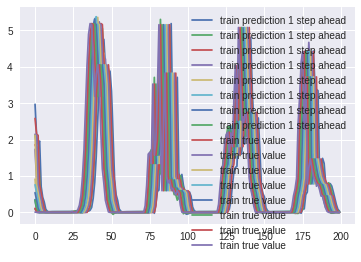

In [42]:
plt.plot(y_train_rescale[-1300:-1100], label='train prediction 1 step ahead')
plt.plot(solar_train_rescale[-1300:-1100], label='train true value')
plt.legend()

In [43]:
## Test 1 step ahead evaluation

with tf.Session() as sess:
    
    saver.restore(sess, save_name)
    
    train_seed = solar_test_origin_scale[:num_time_steps,:].copy()
    y_test_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_test_origin_scale.shape[0]-1):

        #last_train = np.array(train_seed[-num_time_steps:,:-5]).reshape(-1, num_time_steps, 9).copy() #use last type
        last_train = np.array(train_seed[-num_time_steps:,:-7]).reshape(-1, num_time_steps, 12).copy() #use last type
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
        
        train_seed = solar_test_origin_scale[:k+1, :].copy()
            
        y_test_prediction.append(y_pred[0, -1, :].copy())
        
    print('Complete')
        

INFO:tensorflow:Restoring parameters from ./GG6_GRU_model
Complete


In [44]:
# evaluate on test set
y_test_rescale = inverse_transform(np.array(y_test_prediction) , scaler)
solar_test_rescale = inverse_transform(solar_test_origin_scale[:,-8:] , scaler)

rmse = np.sqrt(np.mean(np.square(y_test_rescale  - solar_test_rescale[num_time_steps+1:])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.448765


In [0]:
y_train_rescale
y_test_rescale

df_train = pd.DataFrame(y_train_rescale, columns=['Power prediction','30min Power prediction','60min Power prediction','90min Power prediction','120min Power prediction','150min Power prediction','180min Power prediction','210min Power prediction'])
df_test = pd.DataFrame(y_test_rescale, columns=['Power prediction','30min Power prediction','60min Power prediction','90min Power prediction','120min Power prediction','150min Power prediction','180min Power prediction','210min Power prediction'])
df_test_target = pd.DataFrame(solar_test_rescale, columns=['Power target','30min Power target','60min Power target','90min Power target','120min Power target','150min Power target','180min Power target','210min Power target'])
df_train_target = pd.DataFrame(solar_train_rescale, columns=['Power target','30min Power target','60min Power target','90min Power target','120min Power target','150min Power target','180min Power target','210min Power target'])


df_train.to_csv('GG5_train_eecu.csv')
df_test.to_csv('GG5_test_eecu.csv')
df_test_target.to_csv('GG4_60min_test_target_eecu.csv')
df_train_target.to_csv('GG4_60min_train_target_eecu.csv')


from google.colab import files
files.download('GG5_train_eecu.csv')
files.download('GG5_test_eecu.csv')
files.download('GG4_60min_test_target_eecu.csv')
files.download('GG4_60min_train_target_eecu.csv')

# 5.2 Train and Test forecast steps evaluation

In [46]:
## Train Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, save_name)
    
    train_seed = solar_train_origin_scale[:num_time_steps,:].copy()
    y_train_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_train.shape[0]-1):

        #last_train = np.array(train_seed[-num_time_steps:,:]).reshape(-1, num_time_steps, 3).copy()
        last_train = np.array(train_seed[-num_time_steps:,:-7]).reshape(-1, num_time_steps, 12).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
        
        if count == forecast_steps:
            
            train_seed = solar_train_origin_scale[:k+1, :].copy()
            count = 0
        
        else:
            train_seed = solar_train_origin_scale[:k+1, :].copy()
            train_seed[-1, 0] = y_pred[0, -1, 0].copy()
        
            count += 1
            
        y_train_prediction.append(y_pred[0, -1, 0])
      
    print('Complete')

INFO:tensorflow:Restoring parameters from ./GG6_GRU_model
Complete


In [47]:
# forecast step train eval
rmse = np.sqrt(np.mean(np.square(np.array(y_train_prediction) - solar_train[num_time_steps+1:,2])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.157681


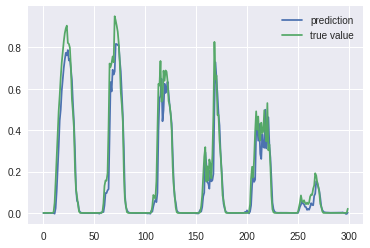

In [48]:
plt.plot(y_train_prediction[-2000:-1700], label='prediction')
plt.plot(solar_train[-2000:-1700,0], label='true value')
plt.legend()

In [49]:
## Test Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, save_name)
    
    train_seed = solar_test_origin_scale[:num_time_steps,:].copy()
    y_test_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_test_origin_scale.shape[0]-1):

        #last_train = np.array(train_seed[-num_time_steps:,:]).reshape(-1, num_time_steps, 4).copy()
        last_train = np.array(train_seed[-num_time_steps:,:-7]).reshape(-1, num_time_steps, 12).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
        
        if count == forecast_steps:
           
            train_seed = solar_test_origin_scale[:k+1, :].copy()
            count = 0
        
        else:
#             train_seed[num_time_steps+1:k+num_time_steps, :] = solar_train[:k, :]
            train_seed = solar_test_origin_scale[:k+1, :].copy()
            train_seed[-1, 0] = y_pred[0, -1, 0].copy()
        
            count += 1
            
        y_test_prediction.append(y_pred[0, -1, 0].copy())
        
    print('Complete')


INFO:tensorflow:Restoring parameters from ./GG6_GRU_model
Complete


In [50]:
# forecast steps test eval
rmse = np.sqrt(np.mean(np.square(np.array(y_test_prediction) - solar_test_origin_scale[num_time_steps+1:,0])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.084241


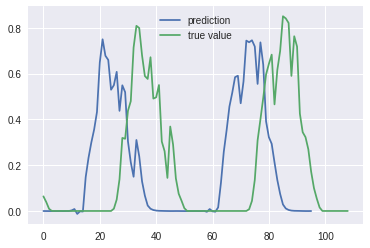

In [51]:
plt.plot(y_test_prediction[-1600:-1200], label='prediction')
plt.plot(solar_test_origin_scale[-1600:-1200,0], label='true value')
plt.legend()